In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Dataset Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [2]:
# Data Loading

train_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/train", transform=transform)
val_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/validation", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
# Check dataset contents
!ls /kaggle/input
!ls /kaggle/input/indianfood15
!ls /kaggle/input/indianfood15/IndianFood15

d  indianfood15
IndianFood15
test  train  validation


In [4]:
# Load ResNet152 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet152 = models.resnet152(pretrained=True)

# Modify fully connected layer 
num_classes = 15
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)
resnet152 = resnet152.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 126MB/s]  


In [5]:
#  Training and Validation 
num_epochs = 30
metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(num_epochs):
    # Training Phase
    resnet152.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet152(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    metrics["train_loss"].append(running_loss / len(train_loader))
    
    # Validation Phase
    resnet152.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet152(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_accuracy"].append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / total:.4f}")
torch.save(resnet152.state_dict(), "resnet152_finetuned.pth")

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30, Train Loss: 1.5033, Val Loss: 34.1276, Val Accuracy: 0.4145
Epoch 2/30, Train Loss: 0.8174, Val Loss: 1.3246, Val Accuracy: 0.6581
Epoch 3/30, Train Loss: 0.6297, Val Loss: 1.4508, Val Accuracy: 0.6609
Epoch 4/30, Train Loss: 0.5095, Val Loss: 0.9578, Val Accuracy: 0.8227
Epoch 5/30, Train Loss: 0.3836, Val Loss: 0.9166, Val Accuracy: 0.7460
Epoch 6/30, Train Loss: 0.3300, Val Loss: 1.0786, Val Accuracy: 0.7167
Epoch 7/30, Train Loss: 0.2718, Val Loss: 1.1431, Val Accuracy: 0.7837
Epoch 8/30, Train Loss: 0.2194, Val Loss: 1.1606, Val Accuracy: 0.7167
Epoch 9/30, Train Loss: 0.2123, Val Loss: 1.2803, Val Accuracy: 0.7537
Epoch 10/30, Train Loss: 0.1726, Val Loss: 0.7874, Val Accuracy: 0.8081
Epoch 11/30, Train Loss: 0.1514, Val Loss: 0.9122, Val Accuracy: 0.7858
Epoch 12/30, Train Loss: 0.1352, Val Loss: 2.5099, Val Accuracy: 0.8081
Epoch 13/30, Train Loss: 0.1816, Val Loss: 2.2131, Val Accuracy: 0.6581
Epoch 14/30, Train Loss: 0.1564, Val Loss: 0.6307, Val Accuracy: 0.8325


In [6]:
# resnet152 = models.resnet152(pretrained=False)  # Load VGG16 architecture
# resnet152.classifier[6] = nn.Linear(4096, 3)  # Adjust output layer for 3 classes
# resnet152.load_state_dict(torch.load("resnet152_finetuned.pth"))  # Load fine-tuned weights
# resnet152 = resnet152.to(device)

# Test  Evaluation
resnet152.eval()
test_labels = []
test_preds = []
test_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet152(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

In [7]:
#  Metrics
test_labels_one_hot = label_binarize(test_labels, classes=range(num_classes))  

precision = precision_score(test_labels, test_preds, average="macro")
recall = recall_score(test_labels, test_preds, average="macro")
f1 = f1_score(test_labels, test_preds, average="macro")
map_score = average_precision_score(test_labels_one_hot, test_probs, average="macro")

print(f"\nTest Metrics:\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1-Score: {f1:.4f}\n"
      f"mAP: {map_score:.4f}")


Test Metrics:
Precision: 0.8545
Recall: 0.8449
F1-Score: 0.8467
mAP: 0.9222


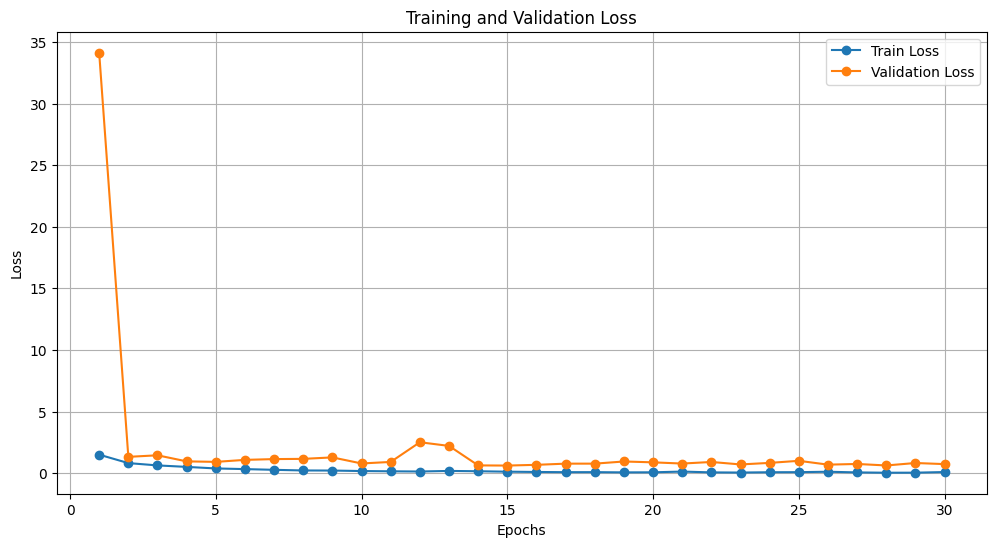

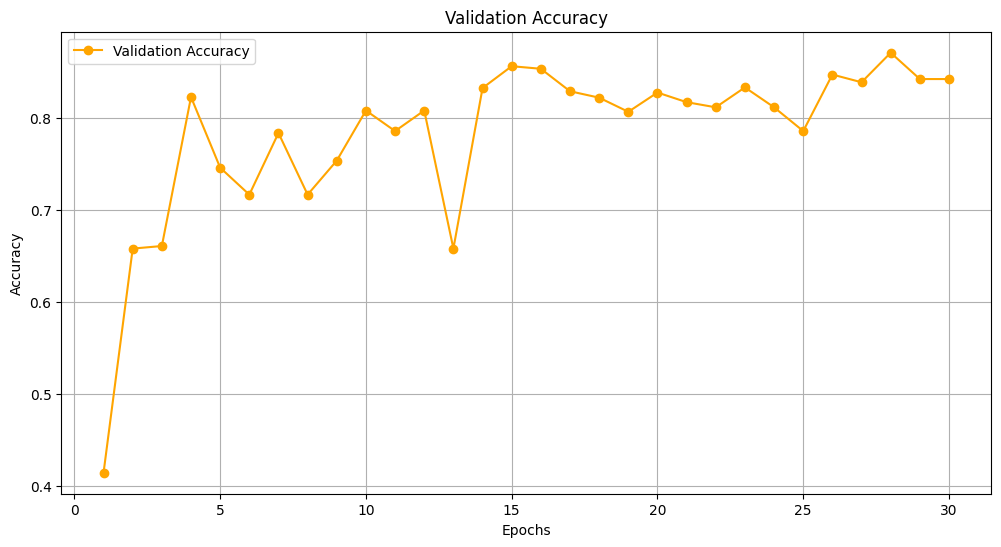

In [8]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), metrics["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["val_accuracy"], label="Validation Accuracy", marker='o', color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()